# Plot of generalization error with spectral adversarial regularization

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%load_ext autoreload
%autoreload 2

import time
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from spectral_adversarial_regularization import dl_utils

%matplotlib inline

In [9]:
def make_plots(arch_name, wd, all_tr_acc, all_va_acc):
    """Generate plot of final train accuracy, final test accuracy v regularization constant"""

    print('For regular %s, tr acc: %.3f, va acc: %.3f, generalization error: %.3f'
          %(arch_name, all_tr_acc['true'][0], all_va_acc['true'][0],
            (1-all_va_acc['true'][0])-(1-all_tr_acc['true'][0])))

    print('For fully sn %s, tr acc: %.3f, va acc: %.3f, generalization error: %.3f'
          %(arch_name, all_tr_acc['true'][1], all_va_acc['true'][1],
            (1-all_va_acc['true'][1])-(1-all_tr_acc['true'][1])))
    
    print('For sn (except for last layer also no wd) %s, tr acc: %.3f, va acc: %.3f, generalization error: %.3f'
          %(arch_name, all_tr_acc['true'][2], all_va_acc['true'][2],
            (1-all_va_acc['true'][2])-(1-all_tr_acc['true'][2])))

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(wd, all_tr_acc['true'][-len(wd):], label='true, training')
    plt.plot(wd, all_va_acc['true'][-len(wd):], label='true, validation')
    plt.plot(wd, all_tr_acc['rand'][-len(wd):], label='random, training')
    plt.plot(wd, all_va_acc['rand'][-len(wd):], label='random, validation')
    plt.xlabel('weight decay')
    plt.xscale('log')
    plt.ylabel('accuracy')
#     plt.ylim(-0.1, 1.1)
    plt.title(arch_name)
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(wd, (1-all_va_acc['true'][-len(wd):])-(1-all_tr_acc['true'][-len(wd):]), label='true')
    plt.plot(wd, (1-all_va_acc['rand'][-len(wd):])-(1-all_tr_acc['rand'][-len(wd):]), label='random')
    plt.xlabel('weight decay')
    plt.xscale('log')
    plt.ylabel('generalization error')
#     plt.ylim(-0.1, 1.1)
    plt.title(arch_name)
    plt.legend()
    plt.grid()

    plt.show()

def compare_performance(main_dir, verbose=True):
    """Recover training and validation accuracies"""
    
    arch_name = main_dir.split('_')[-1]

    all_tr_acc = {'true':[], 'rand':[]}
    all_va_acc = {'true':[], 'rand':[]}
    wd = []

    if verbose: start = time.time()

    for i, f in enumerate(os.listdir(main_dir)):
        if 'wd' in f and i%2 == 0:
            wd.append(float(f.split('wd')[1]))

        save_dir = os.path.join(main_dir, f)
        tr_acc, va_acc = dl_utils.extract_train_valid_tensorboard(save_dir, only_final_value=True)
        all_tr_acc[f.split('_')[1]].append(tr_acc)
        all_va_acc[f.split('_')[1]].append(va_acc)
        if verbose: print('%s done. (%.2f s elapsed)'%(f, time.time()-start))

    for i in all_tr_acc:
        all_tr_acc[i] = np.array(all_tr_acc[i])
        all_va_acc[i] = np.array(all_va_acc[i])
    
    return all_tr_acc, all_va_acc

In [ ]:
# Takes about 9 minutes to run for mlp1, mlp3, alexnet, inception
results = {}
for f in os.listdir('.'):
    if 'save_weights' in f and 'tightsn' not in f and 'small' not in f and 'prototyping' not in f and 'vgg' not in f:
        arch_name = f.split('_')[-1]
        results[arch_name] = compare_performance(f, verbose=True)

For regular alexnet, tr acc: 1.000, va acc: 0.778, generalization error: 0.222
For fully sn alexnet, tr acc: 0.990, va acc: 0.766, generalization error: 0.224
For sn (except for last layer also no wd) alexnet, tr acc: 1.000, va acc: 0.792, generalization error: 0.208


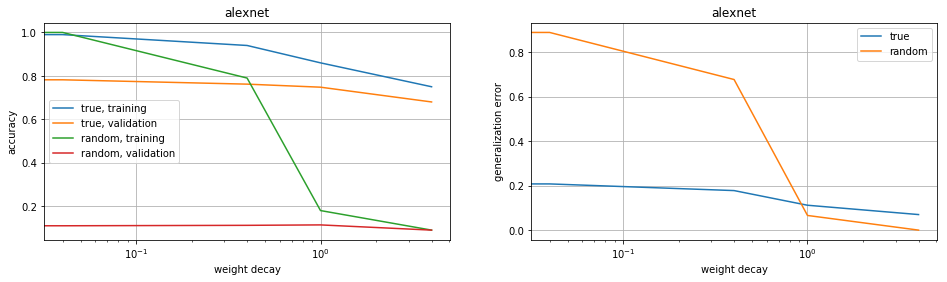

For regular inception, tr acc: 1.000, va acc: 0.864, generalization error: 0.136
For fully sn inception, tr acc: 1.000, va acc: 0.852, generalization error: 0.148
For sn (except for last layer also no wd) inception, tr acc: 1.000, va acc: 0.854, generalization error: 0.146


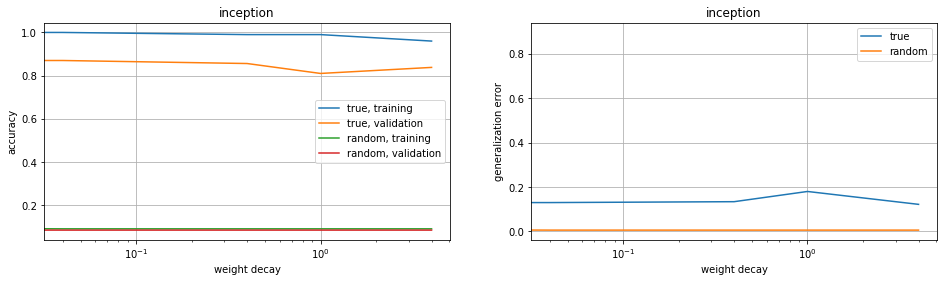

For regular mlp1, tr acc: 0.950, va acc: 0.480, generalization error: 0.470
For fully sn mlp1, tr acc: 0.760, va acc: 0.508, generalization error: 0.252
For sn (except for last layer also no wd) mlp1, tr acc: 1.000, va acc: 0.490, generalization error: 0.510


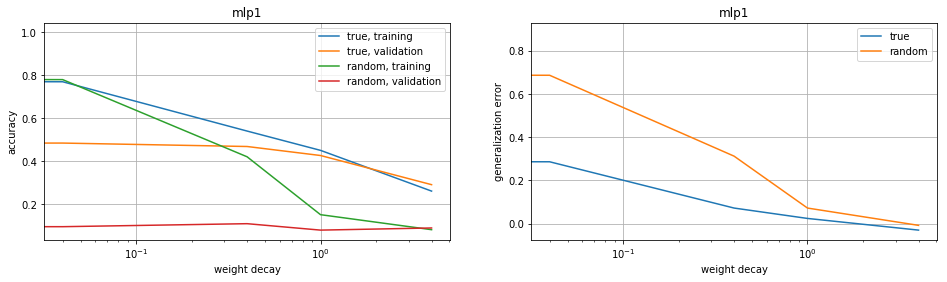

For regular mlp3, tr acc: 1.000, va acc: 0.516, generalization error: 0.484
For fully sn mlp3, tr acc: 0.840, va acc: 0.542, generalization error: 0.298
For sn (except for last layer also no wd) mlp3, tr acc: 1.000, va acc: 0.502, generalization error: 0.498


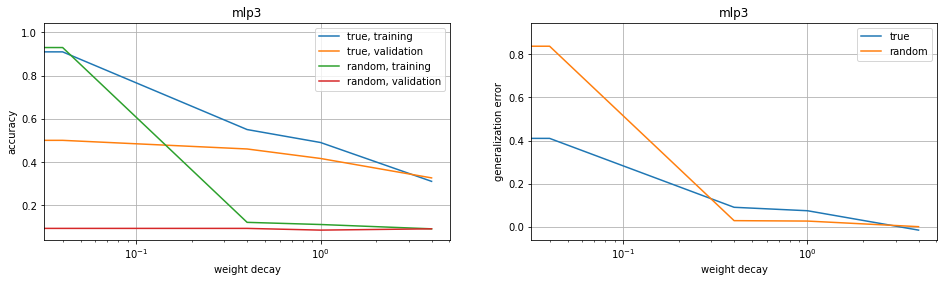

In [10]:
wd = [0, 0.04, 0.4, 1, 4]
for arch_name in sorted(results):
    make_plots(arch_name, wd, results[arch_name][0], results[arch_name][1])

# Visualization of margins

as discussed in Bartlett's [paper](https://arxiv.org/pdf/1706.08498.pdf) (see Figure 2)

In [3]:
from spectral_adversarial_regularization import models
from get_cifar10 import get_cifar10_dataset

# Load dataset
n_samps = 50000

# each value: Xtr, Ytr, Xtt, Ytt
data = {
    'true': get_cifar10_dataset(0, n_samps=n_samps),
    'rand': get_cifar10_dataset(100, n_samps=n_samps)
}

In [67]:
def make_margin_plots_for_all_in_dir(data, maindir, arch_d):
    arch_name = maindir.split('_')[-1]

    start = time.time()
    for f in os.listdir(maindir):
        save_dir = os.path.join(maindir, f)

        if 'rand' in f:
            arch = arch_d[f]
            rand_margins = dl_utils.get_margins(data['rand'][0], data['rand'][1], save_dir, arch=arch)
            save_dir = save_dir.replace('rand', 'true')
            true_margins = dl_utils.get_margins(data['true'][0], data['true'][1], save_dir, arch=arch)

            plt.figure()
            dl_utils.plot_stacked_hist(rand_margins, true_margins, ['rand', 'true'])
            plt.title(f.replace('_rand', '').replace('_true', ''))
            plt.xlabel('margin')
            plt.grid()
            plt.show()

In [68]:
def get_arch_d_str(maindir):
    print('arch_d = {')
    for f in os.listdir(maindir):
        if 'rand' in f:
            last_str = ''
            if '_sn' in f:
                last_str = '_sn'
            elif '_sar' in f:
                last_str = '_sar'
            else:
                last_str = ''

            print('    \''+f+'\': models.%s.%s%s,'
                  %(maindir.split('_')[-1], maindir.split('_')[-1], last_str))
    print('}')

INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand/checkpoints/epoch80
Sanity check: accuracy is 0.99950.
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true/checkpoints/epoch34
Sanity check: accuracy is 0.99858.


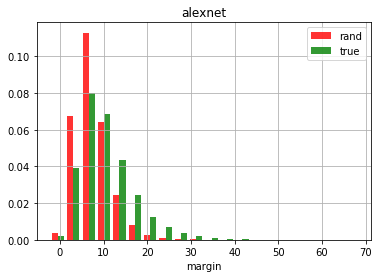

INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand_sn/checkpoints/epoch242
Sanity check: accuracy is 0.99676.
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sn/checkpoints/epoch69
Sanity check: accuracy is 0.99854.


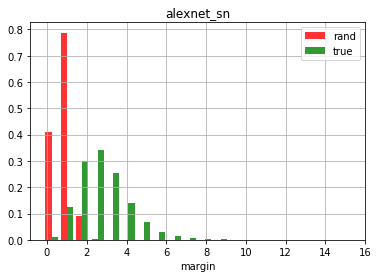

INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand_sar_wd0/checkpoints/epoch48
Sanity check: accuracy is 0.99870.
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sar_wd0/checkpoints/epoch25
Sanity check: accuracy is 1.00000.


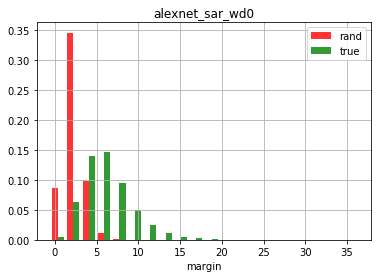

INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand_sar_wd0.04/checkpoints/epoch169
Sanity check: accuracy is 0.99678.
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sar_wd0.04/checkpoints/epoch99
Sanity check: accuracy is 0.99788.


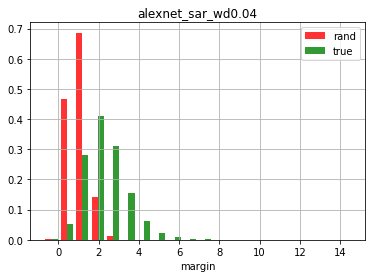

INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand_sar_wd0.4/checkpoints/epoch499
Sanity check: accuracy is 0.82298.
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sar_wd0.4/checkpoints/epoch499
Sanity check: accuracy is 0.97248.


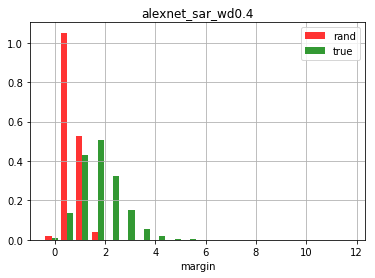

INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand_sar_wd1/checkpoints/epoch499
Sanity check: accuracy is 0.14152.
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sar_wd1/checkpoints/epoch499
Sanity check: accuracy is 0.89570.


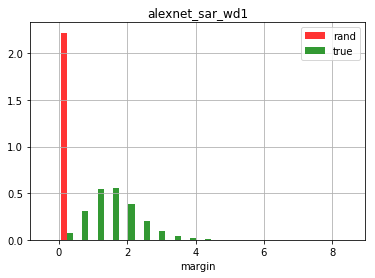

INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand_sar_wd4/checkpoints/epoch499
Sanity check: accuracy is 0.10226.
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sar_wd4/checkpoints/epoch499
Sanity check: accuracy is 0.74854.


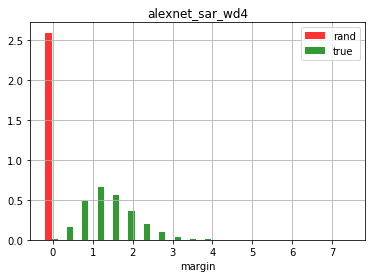

In [69]:
maindir = 'save_weights_n50000_alexnet'
# get_arch_d_str(maindir)

arch_d = {
    'alexnet_rand': models.alexnet.alexnet,
    'alexnet_rand_sn': models.alexnet.alexnet_sn,
    'alexnet_rand_sar_wd0': models.alexnet.alexnet_sar,
    'alexnet_rand_sar_wd0.04': models.alexnet.alexnet_sar,
    'alexnet_rand_sar_wd0.4': models.alexnet.alexnet_sar,
    'alexnet_rand_sar_wd1': models.alexnet.alexnet_sar,
    'alexnet_rand_sar_wd4': models.alexnet.alexnet_sar,
}

make_margin_plots_for_all_in_dir(data, maindir, arch_d)

INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_rand/checkpoints/epoch183
Sanity check: accuracy is 0.99688.
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true/checkpoints/epoch49
Sanity check: accuracy is 0.99714.


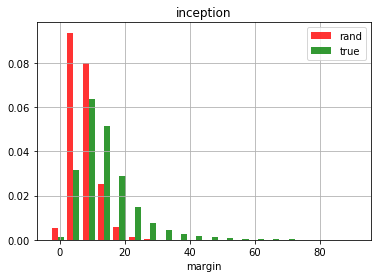

INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_rand_sn/checkpoints/epoch236
Sanity check: accuracy is 0.99922.
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true_sn/checkpoints/epoch76
Sanity check: accuracy is 1.00000.


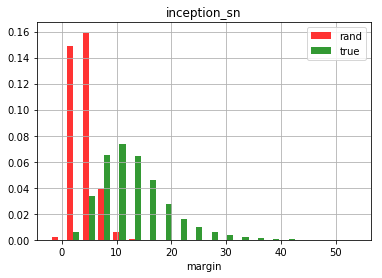

INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_rand_sar_wd0/checkpoints/epoch230
Sanity check: accuracy is 0.99948.
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true_sar_wd0/checkpoints/epoch57
Sanity check: accuracy is 1.00000.


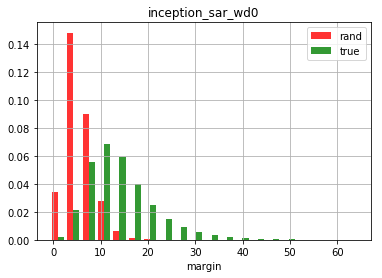

INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_rand_sar_wd0.04/checkpoints/epoch499
Sanity check: accuracy is 0.10010.
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true_sar_wd0.04/checkpoints/epoch144
Sanity check: accuracy is 0.99986.


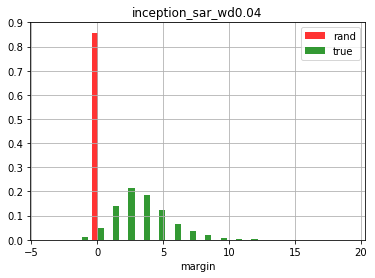

INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_rand_sar_wd0.4/checkpoints/epoch499
Sanity check: accuracy is 0.10010.
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true_sar_wd0.4/checkpoints/epoch499
Sanity check: accuracy is 0.99862.


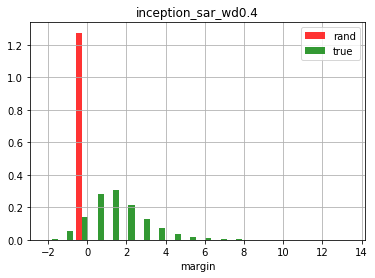

INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_rand_sar_wd1/checkpoints/epoch499
Sanity check: accuracy is 0.10010.
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true_sar_wd1/checkpoints/epoch499
Sanity check: accuracy is 0.98042.


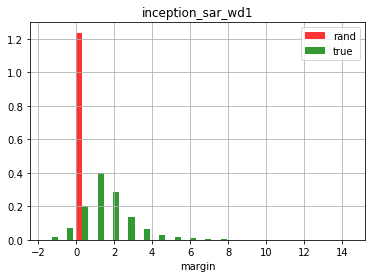

INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_rand_sar_wd4/checkpoints/epoch499
Sanity check: accuracy is 0.10010.
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true_sar_wd4/checkpoints/epoch499
Sanity check: accuracy is 0.96676.


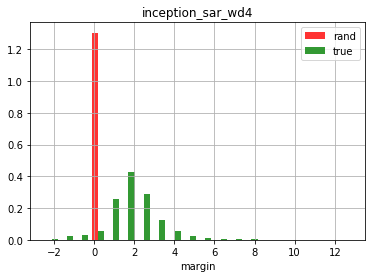

In [71]:
maindir = 'save_weights_n50000_inception'
# get_arch_d_str(maindir)

arch_d = {
    'inception_rand': models.inception.inception,
    'inception_rand_sn': models.inception.inception_sn,
    'inception_rand_sar_wd0': models.inception.inception_sar,
    'inception_rand_sar_wd0.04': models.inception.inception_sar,
    'inception_rand_sar_wd0.4': models.inception.inception_sar,
    'inception_rand_sar_wd1': models.inception.inception_sar,
    'inception_rand_sar_wd4': models.inception.inception_sar,
}

make_margin_plots_for_all_in_dir(data, maindir, arch_d)

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_rand/checkpoints/epoch499
Sanity check: accuracy is 0.95554.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true/checkpoints/epoch499
Sanity check: accuracy is 0.97374.


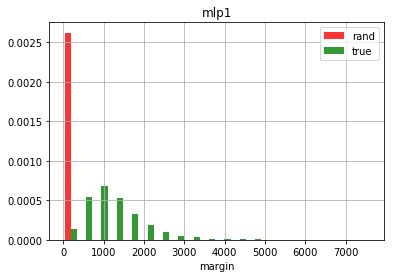

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_rand_sn/checkpoints/epoch499
Sanity check: accuracy is 0.73704.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sn/checkpoints/epoch499
Sanity check: accuracy is 0.85748.


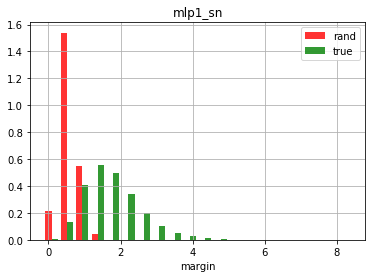

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_rand_sar_wd0/checkpoints/epoch77
Sanity check: accuracy is 0.99818.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sar_wd0/checkpoints/epoch42
Sanity check: accuracy is 0.99952.


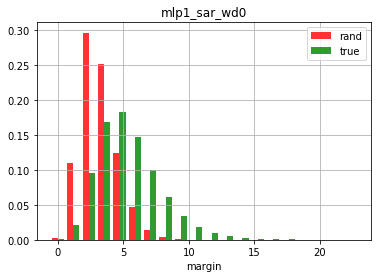

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_rand_sar_wd0.04/checkpoints/epoch499
Sanity check: accuracy is 0.78032.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sar_wd0.04/checkpoints/epoch499
Sanity check: accuracy is 0.87804.


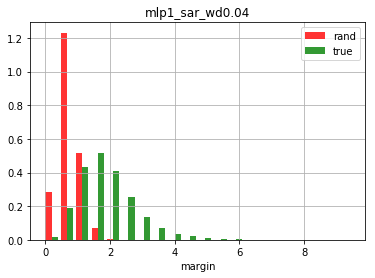

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_rand_sar_wd0.4/checkpoints/epoch499
Sanity check: accuracy is 0.31426.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sar_wd0.4/checkpoints/epoch499
Sanity check: accuracy is 0.57340.


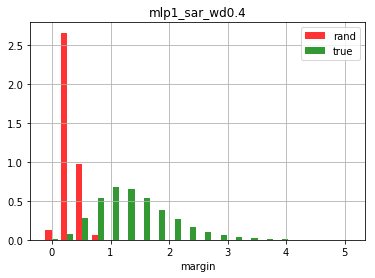

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_rand_sar_wd1/checkpoints/epoch499
Sanity check: accuracy is 0.17242.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sar_wd1/checkpoints/epoch499
Sanity check: accuracy is 0.49956.


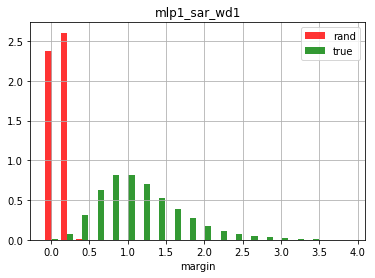

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_rand_sar_wd4/checkpoints/epoch499
Sanity check: accuracy is 0.10728.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sar_wd4/checkpoints/epoch499
Sanity check: accuracy is 0.33740.


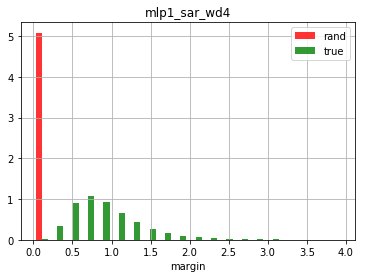

In [74]:
maindir = 'save_weights_n50000_mlp1'
# get_arch_d_str(maindir)

arch_d = {
    'mlp1_rand': models.mlp.mlp1,
    'mlp1_rand_sn': models.mlp.mlp1_sn,
    'mlp1_rand_sar_wd0': models.mlp.mlp1_sar,
    'mlp1_rand_sar_wd0.04': models.mlp.mlp1_sar,
    'mlp1_rand_sar_wd0.4': models.mlp.mlp1_sar,
    'mlp1_rand_sar_wd1': models.mlp.mlp1_sar,
    'mlp1_rand_sar_wd4': models.mlp.mlp1_sar,
}

make_margin_plots_for_all_in_dir(data, maindir, arch_d)

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_rand/checkpoints/epoch499
Sanity check: accuracy is 0.72512.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true/checkpoints/epoch52
Sanity check: accuracy is 1.00000.


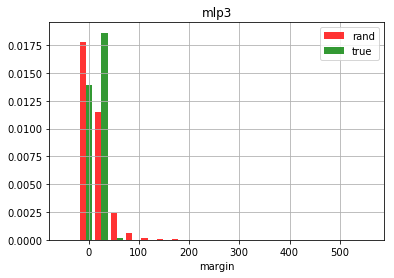

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_rand_sn/checkpoints/epoch499
Sanity check: accuracy is 0.86460.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true_sn/checkpoints/epoch499
Sanity check: accuracy is 0.90598.


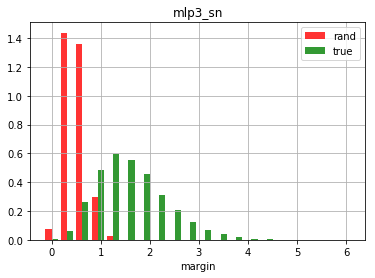

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_rand_sar_wd0/checkpoints/epoch53
Sanity check: accuracy is 0.99938.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true_sar_wd0/checkpoints/epoch37
Sanity check: accuracy is 0.99994.


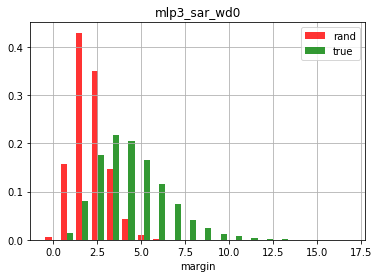

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_rand_sar_wd0.04/checkpoints/epoch499
Sanity check: accuracy is 0.92500.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true_sar_wd0.04/checkpoints/epoch499
Sanity check: accuracy is 0.94402.


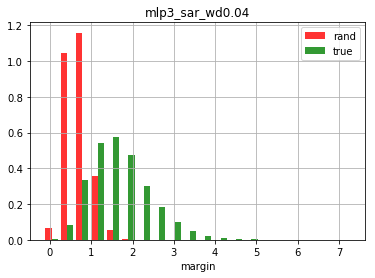

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_rand_sar_wd0.4/checkpoints/epoch499
Sanity check: accuracy is 0.13322.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true_sar_wd0.4/checkpoints/epoch499
Sanity check: accuracy is 0.59386.


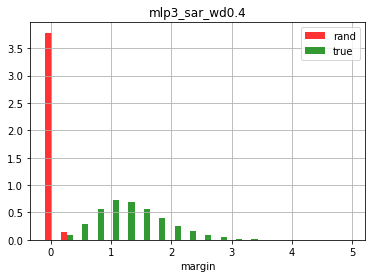

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_rand_sar_wd1/checkpoints/epoch499
Sanity check: accuracy is 0.10010.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true_sar_wd1/checkpoints/epoch499
Sanity check: accuracy is 0.50440.


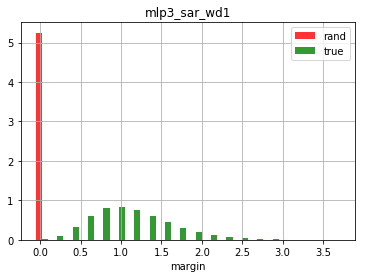

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_rand_sar_wd4/checkpoints/epoch499
Sanity check: accuracy is 0.10062.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true_sar_wd4/checkpoints/epoch499
Sanity check: accuracy is 0.38306.


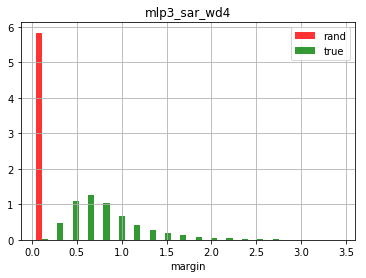

In [75]:
maindir = 'save_weights_n50000_mlp3'
# get_arch_d_str(maindir)

arch_d = {
    'mlp3_rand': models.mlp.mlp3,
    'mlp3_rand_sn': models.mlp.mlp3_sn,
    'mlp3_rand_sar_wd0': models.mlp.mlp3_sar,
    'mlp3_rand_sar_wd0.04': models.mlp.mlp3_sar,
    'mlp3_rand_sar_wd0.4': models.mlp.mlp3_sar,
    'mlp3_rand_sar_wd1': models.mlp.mlp3_sar,
    'mlp3_rand_sar_wd4': models.mlp.mlp3_sar,
}

make_margin_plots_for_all_in_dir(data, maindir, arch_d)